In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.nn.modules.loss import CrossEntropyLoss
from torch.utils.data import Dataset, DataLoader
from torchvision.datasets import MNIST
from torchvision.transforms import ToTensor

In [2]:
# load data
mnist_tr = MNIST('~/.torchvision', train=True, download=True, transform=ToTensor())
mnist_ts = MNIST('~/.torchvision', train=False, download=True, transform=ToTensor())

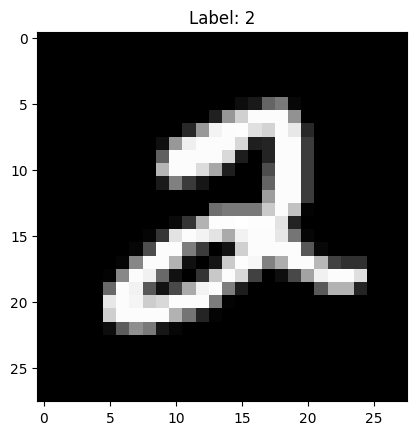

In [3]:
import matplotlib.pyplot as plt

first_image, first_label = mnist_tr[5]
image_to_plot = first_image.squeeze().numpy()
plt.imshow(image_to_plot, cmap='gray')
plt.title(f"Label: {first_label}")
plt.show()

In [4]:
torch.manual_seed(42)

# define CNN
net = nn.Sequential(nn.Conv2d(1, 6, 5), nn.ReLU(),
                    nn.MaxPool2d(2),
                    nn.Conv2d(6, 16, 5), nn.ReLU(),
                    nn.MaxPool2d(2), nn.Flatten(),
                    nn.Linear(256, 120), nn.ReLU(),
                    nn.Linear(120, 84), nn.ReLU(),
                    nn.Linear(84, 10))

# specify the optimization algorithm
optimizer = optim.SGD(net.parameters(), lr=0.1)

# define the loss function
ce = CrossEntropyLoss()

# use a dataloader for sampling mini-batches
trainloader = DataLoader(mnist_tr, batch_size=100, shuffle=True)

# train
print('training...')
nepochs = 3
for epoch in range(nepochs):
    total_loss = 0
    nbatches = 0
    for i, (X_batch, y_batch) in enumerate(trainloader):
        optimizer.zero_grad()
        loss = ce(net(X_batch), y_batch)
        loss.backward()
        optimizer.step()

    total_loss += float(loss)

    print("Epoch %3d: %10f" % (epoch, total_loss/60000))

training...
Epoch   0:   0.000003
Epoch   1:   0.000001
Epoch   2:   0.000001


In [5]:
testloader = DataLoader(mnist_ts, batch_size=100, shuffle=False)

with torch.no_grad():
    y_hat = []
    for i, (X_batch, y_batch) in enumerate(testloader):
        y_hat.append(net(X_batch).argmax(axis=1))

    y_hat = torch.concat(y_hat)

print('Test accuracy:', (y_hat == mnist_ts.targets).float().mean())

Test accuracy: tensor(0.9828)


In [10]:
import PIL
from PIL import Image
import gradio as gr
from torchvision import datasets, transforms

In [15]:
transform = transforms.Compose([
    transforms.Grayscale(),
    transforms.Resize((28, 28)),
    transforms.ToTensor(),
    transforms.RandomInvert(1),
    transforms.Normalize((0.1307,), (0.3081,)) # EXPLORE THIS
])

In [54]:
width, height = 560, 560

def predict_digit(editor_value):
    image = editor_value["composite"]

    background = Image.new('RGBA', image.size, 'WHITE')
    image_with_white_bg = Image.composite(image, background, image)

    transformed_image = transform(image_with_white_bg)

    with torch.no_grad():
        net.eval()
        probs = net(transformed_image.unsqueeze(0)).softmax(axis=1)[0]
        confidences = {str(i): float(prob) for i, prob in enumerate(probs)}
        
    return confidences

In [55]:
import pandas as pd

interface = gr.Interface(fn=predict_digit,
                         inputs=gr.Sketchpad(type="pil", width=width, height=height),
                         outputs="label")

In [57]:
interface.launch(share=True)

Rerunning server... use `close()` to stop if you need to change `launch()` parameters.
----
* Running on public URL: https://45ccfbb512f4a6675b.gradio.live

This share link expires in 72 hours. For free permanent hosting and GPU upgrades, run `gradio deploy` from the terminal in the working directory to deploy to Hugging Face Spaces (https://huggingface.co/spaces)
